# Logistic Regression

redo model training with new data in this script

In [1]:
import pandas as pd
import rdata
from sklearn.linear_model import LogisticRegression
import json
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from functions import get_cv_score
from sklearn.metrics import accuracy_score

Load data

In [2]:
# df_wfc = pd.read_pickle("../data/df_uni_bi_tri_normalized.pickle")
# df_wfc =df_wfc.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

df_sc = pd.read_pickle("../data/df_uni_bi_tri_normalized_SC.pickle")
df_ic = pd.read_pickle("../data/df_uni_bi_tri_normalized_IC.pickle")

df = df_sc.merge(df_ic, on = 'uniform_id')
df =df.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

In [4]:
df.head()


id TF_uni_POS                                                    \
  uniform_id        ADJ       ADP       ADV       AUX     CCONJ       DET   
0       ee_1   0.092952  0.021455  0.068043  0.039998  0.024544  0.025583   
1      ee_12   0.098369  0.036429  0.055563  0.032016  0.009287  0.019285   
2      ee_16   0.090635  0.023712  0.068675  0.038582  0.024094  0.020737   
3      ee_19   0.088778  0.017851  0.059174  0.045878  0.024351  0.029278   
4       ee_2   0.089408  0.022145  0.058950  0.048772  0.012299  0.023303   

                                 ... FF_tri_IC                                \
       NOUN       NUM      PART  ...        21        22        23        24   
0  0.069455  0.162422  0.023479  ...  0.172410  0.168674  0.176803  0.271371   
1  0.071990  0.131555  0.045870  ...  0.153643  0.168770  0.172643  0.447568   
2  0.077147  0.134208  0.036140  ...  0.169928  0.177039  0.168858  0.243441   
3  0.070724  0.106533  0.031707  ...  0.131176  0.126908  0.155958  0.312220   
4  0.082544  0.021347  0.030941  ...  0.196307  0.171843  0.210000  0.280437   

                                                               
         25        26        27        28        30        31  
0  0.263921  0.179121  0.152872  0.122909  0.174318  0.176566  
1  0.384881  0.195568  0.280024  0.093657  0.275122  0.191923  
2  0.298895  0.218182  0.117245  0.131791  0.153952  0.238349  
3  0.218795  0.161457  0.149022  0.104540  0.084703  0.136146  
4  0.285829  0.284697  0.304705  0.182424  0.184710  0.248796  

[5 rows x 5293 columns]

Add language that is going to be the label/ target for model:

In [5]:
# read df with language:
path_ind_diff = r"../data/version 1.1/primary data/individual differences data/joint.ind.diff.l2.rda"
parsed_readrate = rdata.parser.parse_file(path_ind_diff)
converted_readrate = rdata.conversion.convert(parsed_readrate)
df_readrate = converted_readrate['joint_id'][['uniform_id', 'lang']]

# need multiindex to merge properly:
df_readrate.columns = pd.MultiIndex.from_product([['labels'], df_readrate.columns]) 

# join language
df_main = df.merge(df_readrate, left_on = [('id', 'uniform_id')], right_on= [('labels', 'uniform_id')])
df_main = df_main.drop([('labels', 'uniform_id')], axis=1)

# encode language as lables ( using old lookup json):
with open("../data/outputs/language_lookup.json") as json_file:
    language_lookup = json.load(json_file)

df_main[('labels', 'lang_code')] = df_main[('labels', 'lang')].replace(language_lookup).values

In [6]:
df_main.columns.get_level_values(0).unique()

Index(['id', 'TF_uni_POS', 'FP_uni_POS', 'FF_uni_POS', 'TF_bi_POS',
       'FP_bi_POS', 'FF_bi_POS', 'TF_tri_POS', 'FP_tri_POS', 'FF_tri_POS',
       'TF_uni_PTB', 'FP_uni_PTB', 'FF_uni_PTB', 'TF_bi_PTB', 'FP_bi_PTB',
       'FF_bi_PTB', 'TF_tri_PTB', 'FP_tri_PTB', 'FF_tri_PTB', 'TF_uni_UD',
       'FP_uni_UD', 'FF_uni_UD', 'TF_bi_UD', 'FP_bi_UD', 'FF_bi_UD',
       'TF_tri_UD', 'FP_tri_UD', 'FF_tri_UD', 'TF_uni_IC', 'FP_uni_IC',
       'FF_uni_IC', 'TF_bi_IC', 'FP_bi_IC', 'FF_bi_IC', 'TF_tri_IC',
       'FP_tri_IC', 'FF_tri_IC', 'labels'],
      dtype='object')

In [7]:
df_main[('labels', 'lang')].value_counts()

ee    23
fi    23
ge    23
en    21
sp    21
it    20
he    18
Name: (labels, lang), dtype: int64

## Performance graph

In [23]:
import itertools
from tqdm import tqdm

In [ ]:
#only for 4 lang check:
#df_main = df_main[df_main[('labels', 'lang')].isin(['ee', 'fi', 'it', 'sp'])]

dict_performances = {}
dict_performances_groups = []

for i in tqdm(range(2, 8)): # 8
    comb = list(itertools.combinations(['ee', 'fi', 'ge', 'he', 'it', 'en', 'sp'], i))
    print(comb)
    temp = []
    for c in comb:
        #print(c)
        df_main_ = df_main[df_main[('labels', 'lang')].isin(c)]
        logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0)
        columns = ['TF_uni', 'FP_uni', 'FF_uni', 'TF_bi', 'FP_bi', 'FF_bi', 'TF_tri', 'FP_tri', 'FF_tri' ]
        cross_val_scores = get_cv_score(df_main_, columns, logreg)
        dict_performances[str(c)] = np.mean(cross_val_scores)
        temp.append(np.mean(cross_val_scores))
    dict_performances_groups.append([i, np.mean(temp)])

In [7]:
dict_performances

{"('ee', 'fi')": 0.9894736842105264,
 "('ee', 'ge')": 0.9894736842105264,
 "('ee', 'he')": 1.0,
 "('ee', 'it')": 1.0,
 "('ee', 'en')": 1.0,
 "('ee', 'sp')": 1.0,
 "('fi', 'ge')": 0.8947368421052632,
 "('fi', 'he')": 0.8470588235294118,
 "('fi', 'it')": 0.8,
 "('fi', 'en')": 1.0,
 "('fi', 'sp')": 0.7222222222222222,
 "('ge', 'he')": 0.8823529411764707,
 "('ge', 'it')": 0.9666666666666666,
 "('ge', 'en')": 1.0,
 "('ge', 'sp')": 0.9222222222222222,
 "('he', 'it')": 0.875,
 "('he', 'en')": 1.0,
 "('he', 'sp')": 0.7625,
 "('it', 'en')": 1.0,
 "('it', 'sp')": 0.7058823529411764,
 "('en', 'sp')": 1.0,
 "('ee', 'fi', 'ge')": 0.8857142857142858,
 "('ee', 'fi', 'he')": 0.8692307692307691,
 "('ee', 'fi', 'it')": 0.8518518518518517,
 "('ee', 'fi', 'en')": 1.0,
 "('ee', 'fi', 'sp')": 0.6962962962962964,
 "('ee', 'ge', 'he')": 0.9307692307692308,
 "('ee', 'ge', 'it')": 0.9407407407407407,
 "('ee', 'ge', 'en')": 0.9851851851851852,
 "('ee', 'ge', 'sp')": 0.8962962962962964,
 "('ee', 'he', 'it')": 0.9

In [8]:
dict_performances_groups

[[2, 0.9217899732992612],
 [3, 0.8310296063724636],
 [4, 0.7804847302557387],
 [5, 0.7404224814191591],
 [6, 0.7129656507014998],
 [7, 0.6599999999999999]]

In [9]:
import matplotlib.pyplot as plt

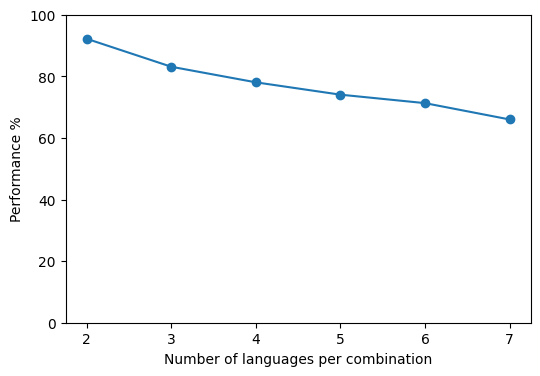

In [12]:

fig, axes = plt.subplots(ncols=1, figsize=(6,4))
axes.plot(np.array(dict_performances_groups)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups)[:, 1]], marker='o')
# mean performance per group of all combinations of languages
#axes.set_title(' Mean performance per group of all possible combinations of languages. E.g. 2 on the x axis means a group all language pairs amd y shows the mean performance.')
axes.set_xlabel('Number of languages per combination')
axes.set_ylabel('Performance %')
axes.set_ylim(0, 100);

## LogReg NLIR

In [8]:
# defining model with correct solver
logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0)

In [9]:
# columns used in training
#columns = ['TF_uni', 'FP_uni', 'FF_uni', 'TF_bi', 'FP_bi', 'FF_bi', 'TF_tri', 'FP_tri', 'FF_tri' ]
columns = [ 'TF_uni_POS', 'FP_uni_POS', 'FF_uni_POS', 'TF_bi_POS',
       'FP_bi_POS', 'FF_bi_POS', 'TF_tri_POS', 'FP_tri_POS', 'FF_tri_POS',
       'TF_uni_PTB', 'FP_uni_PTB', 'FF_uni_PTB', 'TF_bi_PTB', 'FP_bi_PTB',
       'FF_bi_PTB', 'TF_tri_PTB', 'FP_tri_PTB', 'FF_tri_PTB', 'TF_uni_UD',
       'FP_uni_UD', 'FF_uni_UD', 'TF_bi_UD', 'FP_bi_UD', 'FF_bi_UD',
       'TF_tri_UD', 'FP_tri_UD', 'FF_tri_UD', 'TF_uni_IC', 'FP_uni_IC',
       'FF_uni_IC', 'TF_bi_IC', 'FP_bi_IC', 'FF_bi_IC', 'TF_tri_IC',
       'FP_tri_IC', 'FF_tri_IC']

Cross validation score: 

(only needed for report and not for further coding)

In [10]:
cross_val_scores = get_cv_score(df_main, columns, logreg)
print(np.mean(cross_val_scores))
#cross_val_scores # [0.65, 0.5666666666666667, 0.6, 0.5166666666666667, 0.5666666666666667]

5it [00:15,  3.12s/it]

0.6733333333333333
0.6733333333333333


In [11]:
# real train-test split to be used for further analysis: 
train_subset = df_main[columns]
train_label_subset = df_main[('labels', 'lang_code')]

gss = GroupShuffleSplit(n_splits=5, test_size = 0.3, random_state=42)
split_indexes = list(gss.split(train_subset, train_label_subset, df_main[('id','uniform_id')]))[0]
train_idx = list(split_indexes[0])
test_idx = list(split_indexes[1])

X_train = train_subset.iloc[train_idx]
y_train = train_label_subset.iloc[train_idx]
X_test = train_subset.iloc[test_idx]
y_test = train_label_subset.iloc[test_idx]

test_lang = df_main[('labels', 'lang')].iloc[test_idx]
test_lang_codes = df_main[('labels', 'lang_code')].iloc[test_idx]

In [12]:
# fit model:
logreg.fit(X_train, y_train)

# only for score count:
y_pred = logreg.predict(X_test)
test_acc_score = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {test_acc_score}; overall cross validation accuracy {np.mean(cross_val_scores)}')
# Test set accuracy: 0.6888888888888889; overall cross validation accuracy 0.5800000000000001 for all languages
# Test set accuracy: 0.4074074074074074; overall cross validation accuracy 0.4914285714285714 for 4 languages


Test set accuracy: 0.7555555555555555; overall cross validation accuracy 0.6733333333333333


Test set accuracy: 0.7857142857142857; overall cross validation accuracy 0.6736842105263158 for ee - fi (46)

Test set accuracy: 0.8571428571428571; overall cross validation accuracy 0.711111111111111 for ee - sp (44)

Test set accuracy: 0.7692307692307693; overall cross validation accuracy 0.8 for ee -it  (43)

Test set accuracy: 0.5384615384615384; overall cross validation accuracy 0.8222222222222222 fi it (43)

Test set accuracy: 0.5714285714285714; overall cross validation accuracy 0.6555555555555556 fi sp (44)

Test set accuracy: 0.7692307692307693; overall cross validation accuracy 0.6823529411764706 it sp (41)



Test set accuracy: 0.5238095238095238; overall cross validation accuracy 0.5407407407407407 ee fi sp 

Test set accuracy: 0.55; overall cross validation accuracy 0.6814814814814815 ee fi it

Test set accuracy: 0.55; overall cross validation accuracy 0.6923076923076923 ee sp it

Test set accuracy: 0.5; overall cross validation accuracy 0.6538461538461539 fi sp it



















### LogReg Similarity

Create dictionary with df for each language separately to be used for similarity metrics:

In [13]:
X_test['lang'] = test_lang # add language column
languages = list(test_lang.unique())
dict_lang = {}
for ll in languages:
    df = X_test[X_test['lang'] == ll]
    dict_lang[ll] = df


dict_proba ={}
len_dfs = []
lang_identifier = []
for key in dict_lang.keys():
    lang_df = dict_lang[key][columns]
    test_proba = logreg.predict_proba(lang_df) # predicting probabilities here
    len_df = len(lang_df)
    test_proba = test_proba.sum(axis=0)   # sum bc they are normalised by number of participants
    dict_proba[key] = test_proba
    len_dfs.append(len_df) # record length of language df
    lang_identifier.append(key)

/tmp/ipykernel_1630/2390796384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lang'] = test_lang # add language column


In [14]:
# to pandas:
df_predictions = pd.DataFrame(dict_proba).reset_index()
# cols are lang on which predicted and rows are outputs

# add col with lenghts and lang name
df_predictions['length'] = len_dfs
df_predictions['lang'] = lang_identifier

In [15]:
df_predictions

,index,ee,en,fi,ge,he,it,sp,length,lang
0,0,9.996996e+00,3.169161e-09,7.480607e-08,1.500827e-07,3.779243e-11,1.562937e-08,0.000007,10,ee
1,1,1.385463e-08,7.999855e+00,3.152839e-09,1.108592e-12,4.518022e-13,1.315301e-05,0.000016,8,en
2,2,2.236696e-03,1.448547e-04,4.100573e+00,9.267813e-02,7.806814e-02,6.145701e-01,2.312962,6,fi
3,3,4.297486e-06,1.869802e-07,4.145733e-05,6.732247e+00,4.731454e-05,1.101387e-01,0.044016,8,ge
4,4,2.192988e-06,1.959544e-08,5.829427e-03,7.639097e-01,9.997330e-01,2.010397e-01,0.022550,2,he
5,5,6.762812e-04,2.314021e-08,1.197178e-02,1.142946e-01,5.199126e-01,3.262788e+00,2.331372,6,it
6,6,8.449262e-05,1.015768e-07,1.881584e+00,2.968701e-01,4.022390e-01,1.811450e+00,0.289077,5,sp


Convert into pair dictionary:

In [16]:
lang_values = []
lang_pairs = []
#lang_similarities = {}
for key1 in df_predictions['lang'].unique(): 
    for key2 in df_predictions['lang'].unique(): 
        val1 = float(df_predictions[df_predictions['lang'] == key1][key2])
        val2 = float(df_predictions[df_predictions['lang'] == key2][key1])
        len1 = float(df_predictions[df_predictions['lang'] == key1]['length'])
        len2 = float(df_predictions[df_predictions['lang'] == key2]['length'])
        
        #lang_similarities[f'{key1}_{key2}'] = ((val1 + val2) /(len1+len2)) #  divide by corpus length bc summed above
        lang_values.append((val1 + val2) / (len1+len2))
        lang_pairs.append(f'{key1}_{key2}')

In [17]:
df_lang_similarities = pd.DataFrame({'pair': lang_pairs, 'logreg_val': lang_values})

In [18]:
# inverted 
df_lang_similarities['logreg_val_inverted'] = 1 - df_lang_similarities['logreg_val']

In [19]:
#lang_similarities # invert as 1- proba. 
df_lang_similarities

,pair,logreg_val,logreg_val_inverted
0,ee_ee,9.996996e-01,0.000300
1,ee_en,9.457663e-10,1.000000
2,ee_fi,1.397982e-04,0.999860
3,ee_ge,2.470871e-07,1.000000
4,ee_he,1.827521e-07,1.000000
5,ee_it,4.226855e-05,0.999958
6,ee_sp,6.100130e-06,0.999994
7,en_ee,9.457663e-10,1.000000
8,en_en,9.999819e-01,0.000018
9,en_fi,1.034699e-05,0.999990


In [20]:
# write 

df_lang_similarities.to_csv("../data/outputs/logreg_similarity_SC_IC.csv", index = False) # rename for other saves

**ToDos:**

- investigate why 4 lang perform worse than all. maybe try with 2? ( very different and very similar - eg ee vs fi and ee and sp)
- do separate runs with only bi and bi+tri-grams and fill table in report
- plot language tree using both similarity metrics
- do majority class baseline (cv accuracy only)

